In [1]:
import sys, os, glob, pickle, toml, json
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr

def set_background(ax):
    ax.set_extent([-121, -72, 25, 50])

    # Background boundaries
    # ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray')
    
    return ax


def cal_ratio_within_bins(data, bins):
    binsc = np.zeros(len(bins)-1)
    ratio = np.zeros(len(bins)-1)
    for i in range(len(bins)-1):
        indi = (data>bins[i]) & (data<=bins[i+1])
        ratio[i] = np.sum(indi)/np.sum(~np.isnan(data))
        binsc[i] = (bins[i]+bins[i+1])/2
    return binsc, ratio



In [2]:
# load info
infile_basin_info = f"/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv"
df_info = pd.read_csv(infile_basin_info)

# input/out and iteration information
iternum = 8
inpath_moasmo = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_emulator/'

In [3]:
    # LSE metrics

    df_lse_metric = []

    for tarbasin in range(len(df_info)):
    # for tarbasin in range(5):
        for i in range(iternum):
            infile = f'{inpath_moasmo}/level1_{tarbasin}_calib/ctsm_outputs_LSEnormKGE/iter{i}_many_metrics_mizuroute_s-1.csv'    
            dfi = pd.read_csv(infile)
            dfi['basin'] = tarbasin
            dfi['iter'] = i
            dfi['trial'] = np.arange(len(dfi))
            if len(df_lse_metric) == 0:
                df_lse_metric = dfi
            else:
                df_lse_metric = pd.concat([df_lse_metric, dfi])

In [4]:
# check nan ratio of each iteration
metname = 'kge'
nanratio = np.nan * np.zeros([len(df_info), iternum]) # best; mean; median
for i in range(iternum):
    indi = (df_lse_metric['iter']==i)
    for j in range(len(df_info)):
        indij = indi & (df_lse_metric['basin']==j)
        dij = df_lse_metric[indij][metname].values
        nanratio[j, i] = np.sum(np.isnan(dij)) / len(dij)

print('nan ratio of each iteration')
print(np.nanmean(nanratio, axis=0))

nan ratio of each iteration
[0.0092823  0.02239234 0.02315789 0.03001595 0.02038278 0.02992026
 0.02408293 0.0261244 ]


In [5]:
# statistics-1: best metric of each iteration
metname = 'kge'
met_defa = np.nan * np.zeros(len(df_info))
met_stats_lse = np.nan * np.zeros([len(df_info), iternum, 3]) # best; mean; median
for i in range(iternum):
    indi = (df_lse_metric['iter']==i)
    for j in range(len(df_info)):
        indij = indi & (df_lse_metric['basin']==j)
        dij = df_lse_metric[indij][metname].values

        met_stats_lse[j, i, 0] = np.nanmax(dij)
        met_stats_lse[j, i, 1] = np.nanmean(dij)
        met_stats_lse[j, i, 2] = np.nanmedian(dij)

        if i == 0:
            met_defa[j] = dij[0]

print('median defa:', np.nanmedian(met_defa))
print('best of each iteration')
print(np.nanmedian(met_stats_lse[:,:,0], axis=0))

/glade/derecho/scratch/guoqiang/tmp/ipykernel_34950/3571003834.py:11: RuntimeWarning: All-NaN slice encountered
  met_stats_lse[j, i, 0] = np.nanmax(dij)
/glade/derecho/scratch/guoqiang/tmp/ipykernel_34950/3571003834.py:12: RuntimeWarning: Mean of empty slice
  met_stats_lse[j, i, 1] = np.nanmean(dij)
/glade/derecho/scratch/guoqiang/tmp/ipykernel_34950/3571003834.py:13: RuntimeWarning: All-NaN slice encountered
  met_stats_lse[j, i, 2] = np.nanmedian(dij)


median defa: 0.2924950605896708
best of each iteration
[0.50298218 0.54375766 0.58163291 0.60354144 0.62079243 0.62886933
 0.63718439 0.64539144]


In [6]:
# statistics-2: best metric of all iterations (e.g., for iter-2, this is the best from iter0+iter1+iter2)

metname = 'kge'
met_defa = np.nan * np.zeros(len(df_info))
met_stats_lse = np.nan * np.zeros([len(df_info), iternum, 3]) # best; mean; median
for i in range(iternum):
    indi = (df_lse_metric['iter']<=i)
    for j in range(len(df_info)):
        indij = indi & (df_lse_metric['basin']==j)
        dij = df_lse_metric[indij][metname].values

        met_stats_lse[j, i, 0] = np.nanmax(dij)
        met_stats_lse[j, i, 1] = np.nanmean(dij)
        met_stats_lse[j, i, 2] = np.nanmedian(dij)

        if i == 0:
            met_defa[j] = dij[0]

print('median defa:', np.nanmedian(met_defa))
print('best of each iteration')
print(np.nanmedian(met_stats_lse[:,:,0], axis=0))


median defa: 0.2924950605896708
best of each iteration
[0.50298218 0.55676778 0.59312039 0.61411995 0.62495204 0.63674595
 0.6445356  0.65307486]


(0.0, 1.0)

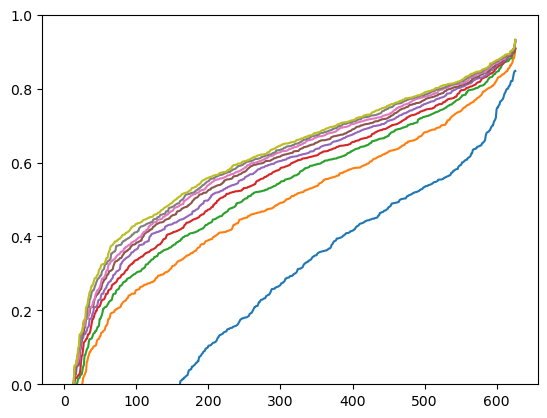

In [7]:
plt.plot(np.sort(met_defa))
for i in range(iternum):
    plt.plot(np.sort(met_stats_lse[:,i,0]))

plt.ylim(0,1)